<a href="https://colab.research.google.com/github/michalinahulak/kickstarter_project/blob/main/kickstarter_en.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


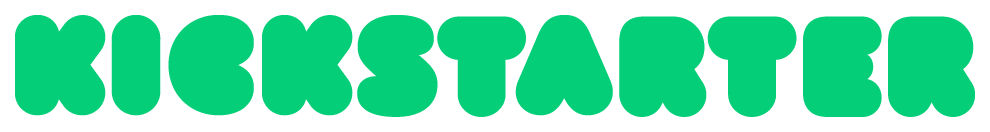
# Introduction

Project carried out as a part of learning and exercises during the Data Science course. Includes classification issues.

The kickstarter platform was founded in 2009. It is an English-language crowdfunding site where fundraisers are conducted for various projects (musical, artistic, etc.).

The imported data includes columns with information about collections, including name of the fundraiser, start and end date, set fundraiser goal, category, number of supporters and country.

# The purpose of the project

The aim of the project is to build a model that determines the success of the fundraiser based on data that can be obtained even before the start of the fundraising. From a business point of view, it is useful to determine whether we are successful or not before starting the fundraiser.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!ls -la '/content/drive/My Drive/Colab Notebooks/kickstarter projekt'

In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/kickstarter projekt

# Imports

In [ ]:
pip install ydata-profiling

In [ ]:
!pip install session-info

In [ ]:
!pip install --upgrade scikit-learn

In [ ]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import sklearn
import time

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

from wordcloud import WordCloud, STOPWORDS
from PIL import Image

from ydata_profiling import ProfileReport

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [ ]:
import session_info
session_info.show()

In [ ]:
# import and interactive dataset

%load_ext google.colab.data_table

kick_set = pd.read_csv('kickstarter_dataset', index_col='ID')
kick_set.drop('Unnamed: 0', axis=1, inplace=True)
kick_set.head(20000)

name        category  \
ID                                                                              
1533052736                      Ornamental - Mental ornaments  Product Design   
1397944046  Let Me Introduce Myself; Dani Joy's Debut Ukul...            Jazz   
165265988   Enabling Young Travelers on a Budget to Explor...             Web   
276808753         The Dwarves - A New Storydriven Fantasy RPG     Video Games   
1487389447                             Pared Down Productions         Musical   
...                                                       ...             ...   
770851472   A lead pump for SEALER: Swedish Advanced Lead ...        Hardware   
58546462                      The Last Goodbye - feature film  Narrative Film   
1138242023                                  Mirari's Art Shop        Painting   
137566299   The NuPrime Multizone WiFi Audio System & Cels...           Sound   
458330388   THE KICKSTARTER LETTERS: a handmade & illustra...      Publishing   

           main_category currency    deadline      goal             launched  \
ID                                                                             
1533052736        Design      GBP  2013-09-12   19600.0  2013-08-13 08:31:14   
1397944046         Music      USD  2014-06-10    6000.0  2014-05-11 05:02:13   
165265988     Journalism      GBP  2016-04-19   10000.0  2016-03-20 00:54:31   
276808753          Games      USD  2015-10-08  260000.0  2015-09-01 10:55:56   
1487389447       Theater      USD  2015-08-26    4000.0  2015-06-27 04:35:53   
...                  ...      ...         ...       ...                  ...   
770851472     Technology      USD  2014-05-18  300000.0  2014-04-15 12:42:06   
58546462    Film & Video      AUD  2014-03-27   14520.0  2014-02-21 00:26:17   
1138242023           Art      AUD  2014-05-02     500.0  2014-03-31 03:48:18   
137566299     Technology      USD  2016-04-21   10000.0  2016-03-22 02:22:37   
458330388     Publishing      USD  2012-11-21    2500.0  2012-10-22 16:27:43   

           country  supporters       state  
ID                                          
1533052736      GB      1572.0      failed  
1397944046      US         NaN  successful  
165265988       GB      3305.0      failed  
276808753       US         NaN  successful  
1487389447      US      1910.0  successful  
...            ...         ...         ...  
770851472       US         NaN      failed  
58546462        AU       403.0  successful  
1138242023      AU         NaN  successful  
137566299       US      2288.0      failed  
458330388       US      1238.0  successful  

[20000 rows x 10 columns]

In [ ]:
%unload_ext google.colab.data_table

# Functions

In [ ]:
# Metric counting function

def calculate_metrics(truth, predicted, average = 'weighted'):    
    accuracy = round(accuracy_score(truth, predicted),2)
    precision = round(precision_score(truth, predicted, average=average),2)
    recall = round(recall_score(truth, predicted, average=average),2)
    fscore = round(f1_score(truth, predicted, average=average),2)
    
    total = len(truth)
    mislabeled = (truth !=predicted).sum()
    return accuracy, precision, recall, fscore, total, mislabeled

In [ ]:
# Printing results

def print_result(metrics, classifier_id = 'classifier'):    
    print(f'Result for {classifier_id} \n')
    print(f'Accuracy: {metrics[0]}')
    print(f'Precision: {metrics[1]}')
    print(f'Recall: {metrics[2]}')
    print(f'F-Score: {metrics[3]}')
    print(f'Total: {metrics[4]}')
    print(f'Mislabeled: {metrics[5]} \n')

# ydata-profiling

In [ ]:
profile = ProfileReport(kick_set, title="Profiling Report")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:02<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Pre-processing

In [ ]:
kick_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 297840 entries, 1533052736 to 1248939259
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   name           297836 non-null  object 
 1   category       297840 non-null  object 
 2   main_category  297840 non-null  object 
 3   currency       297840 non-null  object 
 4   deadline       297840 non-null  object 
 5   goal           268027 non-null  float64
 6   launched       297840 non-null  object 
 7   country        297840 non-null  object 
 8   supporters     208505 non-null  float64
 9   state          297840 non-null  object 
dtypes: float64(2), object(8)
memory usage: 25.0+ MB


## Delete rows with 'canceled' value in 'state' column
Fundraisers whose status is 'canceled' have been canceled by the people who created them. The reasons for canceling fundraisers are not known. It is unknown whether the canceled fundraisers would have been a success or a failure.
The purpose of the app is to define success or failure.

In [ ]:
kick_set.drop(kick_set.index[kick_set['state'] == 'canceled'], inplace = True)

## Date

In [ ]:
#change DataTime format

kick_set['deadline'] = pd.to_datetime(kick_set['deadline'], format = '%Y/%m/%d')     
kick_set['launched'] = pd.to_datetime(kick_set['launched'], format = '%Y/%m/%d')

In [ ]:
# remove row in 'launched' column with Nan

kick_set.dropna(subset=['launched'], inplace=True)

In [ ]:
#separate 'launch' in date and time

kick_set['launch_date'] = [d.date() for d in kick_set['launched']]     
kick_set['launch_time'] = [d.time() for d in kick_set['launched']]
kick_set.head()

name        category  \
ID                                                                              
1533052736                      Ornamental - Mental ornaments  Product Design   
1397944046  Let Me Introduce Myself; Dani Joy's Debut Ukul...            Jazz   
165265988   Enabling Young Travelers on a Budget to Explor...             Web   
276808753         The Dwarves - A New Storydriven Fantasy RPG     Video Games   
1487389447                             Pared Down Productions         Musical   

           main_category currency   deadline      goal            launched  \
ID                                                                           
1533052736        Design      GBP 2013-09-12   19600.0 2013-08-13 08:31:14   
1397944046         Music      USD 2014-06-10    6000.0 2014-05-11 05:02:13   
165265988     Journalism      GBP 2016-04-19   10000.0 2016-03-20 00:54:31   
276808753          Games      USD 2015-10-08  260000.0 2015-09-01 10:55:56   
1487389447       Theater      USD 2015-08-26    4000.0 2015-06-27 04:35:53   

           country  supporters       state launch_date launch_time  
ID                                                                  
1533052736      GB      1572.0      failed  2013-08-13    08:31:14  
1397944046      US         NaN  successful  2014-05-11    05:02:13  
165265988       GB      3305.0      failed  2016-03-20    00:54:31  
276808753       US         NaN  successful  2015-09-01    10:55:56  
1487389447      US      1910.0  successful  2015-06-27    04:35:53

In [ ]:
# change DataTime format

kick_set['launch_date'] = pd.to_datetime(kick_set['launch_date'], format = '%Y/%m/%d')

kick_set['launch_time'] = pd.to_datetime(kick_set['launch_time'], format='%H:%M:%S')

In [ ]:
#create new column 'days' with the duration of the fundraising, given in days

kick_set['days'] = (kick_set['deadline'] - kick_set['launch_date']) / np.timedelta64(1, 'D')

In [ ]:
# classification of 'launch time' for different times of the day and night
# 0 - 6
# 6 - 12
# 12 - 18
# 18 - 22
# 22 - 24


# define bins and labels
bins = ['00:00:00', '06:00:00', '12:00:00', '18:00:00', '22:00:00', '23:59:59']
labels = ['0-6' , '6-12', '12-18', '18-22', '22-24']

# convert to timedelta
s = pd.to_timedelta(pd.to_datetime(kick_set['launched']).dt.time.astype(str))
kick_set['launch_hour'] = pd.cut(s, bins=pd.to_timedelta(bins), labels=labels, ordered=False)

In [ ]:
# remove the 'launched', 'launch_time' columns so it doesn't duplicate

kick_set.drop('launched', axis=1, inplace=True) 
kick_set.drop('launch_time', axis=1, inplace=True)


In [ ]:
# Kickstarter was founded in 2009. Fundraising filtration set up earlier than 2009 - such dates were set incorrectly.

kick_set[kick_set['launch_date'] < '2009-01-01']

Empty DataFrame
Columns: [name, category, main_category, currency, deadline, goal, country, supporters, state, launch_date, days, launch_hour]
Index: []

## Missing values

In [ ]:
kick_set.isnull().sum()

name                 4
category             0
main_category        0
currency             0
deadline             0
goal             26719
country              0
supporters       80058
state                0
launch_date          0
days                 0
launch_hour          6
dtype: int64

### Missing values in 'name' column
The founder of the fundraiser might not have given the title by mistake, so replace the missing values ​​with '0'

In [ ]:
kick_set[kick_set['name'].isnull()]

name        category main_category currency   deadline      goal  \
ID                                                                            
796533179   NaN        Painting           Art      USD 2011-12-05   35000.0   
634871725   NaN     Video Games         Games      GBP 2013-01-06    2000.0   
648853978   NaN  Product Design        Design      USD 2016-07-18    2500.0   
1848699072  NaN  Narrative Film  Film & Video      USD 2012-02-29  200000.0   

           country  supporters   state launch_date  days launch_hour  
ID                                                                    
796533179       US         NaN  failed  2011-11-06  29.0       22-24  
634871725       GB         NaN  failed  2012-12-19  18.0       22-24  
648853978       US      1905.0  failed  2016-06-18  30.0         0-6  
1848699072      US       203.0  failed  2012-01-01  59.0       12-18

In [ ]:
# replace the missing values ​​with '0'
kick_set['name']=kick_set['name'].fillna('0')

### Missing values in 'goal' column

Perhaps there was no fundraising goal and whatever amount raised was satisfactory, fill in with 0.

In [ ]:
kick_set['goal'] = kick_set['goal'].fillna(0)

In [ ]:
kick_set.isnull().sum()

name                 0
category             0
main_category        0
currency             0
deadline             0
goal                 0
country              0
supporters       80058
state                0
launch_date          0
days                 0
launch_hour          6
dtype: int64

### Missing values in 'launch_hour' column

In [ ]:
kick_set[kick_set['launch_hour'].isnull()]

name  \
ID                                                              
517927477                                 Here's the scoop...   
1687698504              Bringing elegance back ... with hats!   
1755957374  Mollö entdeckt die Welt- das Kinderbuch das wa...   
1953025800    Discover the Painting Pyramid with James Wappel   
515031443                                       One Bad Night   
632771782                               Country Tough Apparel   

                    category main_category currency   deadline     goal  \
ID                                                                        
517927477               Food          Food      GBP 2014-09-21  10000.0   
1687698504           Couture       Fashion      USD 2015-02-10   3000.0   
1755957374  Children's Books    Publishing      EUR 2016-10-16      0.0   
1953025800          Painting           Art      USD 2013-02-09   8000.0   
515031443              Music         Music      USD 2012-09-27   1000.0   
632771782            Apparel       Fashion      USD 2016-07-29  15000.0   

           country  supporters       state launch_date  days launch_hour  
ID                                                                        
517927477       GB      1605.0      failed  2014-07-23  60.0         NaN  
1687698504      US      1865.0      failed  2015-01-06  35.0         NaN  
1755957374      DE         NaN      failed  2016-09-16  30.0         NaN  
1953025800      US      1307.0  successful  2013-01-10  30.0         NaN  
515031443       US         NaN      failed  2012-09-07  20.0         NaN  
632771782       US         NaN      failed  2016-06-29  30.0         NaN

In [ ]:
kick_set.dropna(subset=['launch_hour'], inplace=True)

## Extracting data from the 'name' column

### 'title_length' column

In [ ]:
# Create a 'title_lenght' column and count the characters in the title

kick_set['title_lenght'] = kick_set['name'].str.len() 

### Word requency in 'name' column

In [ ]:
kick_freq = kick_set.copy()

kick_freq["title_lower"] = kick_freq['name'].str.lower().str.replace('[^\w\s]','')
words_freq = kick_freq.title_lower.str.split(expand=True).stack().value_counts().reset_index()
 
words_freq.columns = ['Word', 'Frequency'] 
 
words_freq.head(10)

<ipython-input-31-95cda7ce5bdc>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  kick_freq["title_lower"] = kick_freq['name'].str.lower().str.replace('[^\w\s]','')


Word  Frequency
0    the      74750
1      a      36612
2     of      26701
3    and      18096
4    for      16873
5     to      14750
6     in      12750
7  album      10129
8    new       9932
9   film       8463

In [ ]:
kick_new = kick_freq[kick_freq['title_lower'].str.contains('new')]
kick_new.head()

name     category  \
ID                                                                           
276808753         The Dwarves - A New Storydriven Fantasy RPG  Video Games   
270411657          LONDON BLUSION - Album - Genre : New Blues        Blues   
2095335534  Newsprint Mural 4 Berlin Café (Painting + Travel)     Painting   
1510757601  Combine 2 Demos to make new Record "The Year I...   Indie Rock   
955336537   Graham Show New Single Release in High Definit...         Rock   

           main_category currency   deadline      goal country  supporters  \
ID                                                                           
276808753          Games      USD 2015-10-08  260000.0      US         NaN   
270411657          Music      GBP 2017-04-14    3000.0      GB      1426.0   
2095335534           Art      USD 2013-11-01    1200.0      US         NaN   
1510757601         Music      USD 2013-12-24    3300.0      US       189.0   
955336537          Music      CAD 2014-04-22    3000.0      CA      1736.0   

                 state launch_date  days launch_hour  title_lenght  \
ID                                                                   
276808753   successful  2015-09-01  37.0        6-12            43   
270411657   successful  2017-03-15  30.0       12-18            42   
2095335534  successful  2013-10-16  16.0        6-12            49   
1510757601      failed  2013-12-02  22.0        6-12            58   
955336537       failed  2014-03-25  28.0         0-6            55   

                                                  title_lower  
ID                                                             
276808753          the dwarves  a new storydriven fantasy rpg  
270411657             london blusion  album  genre  new blues  
2095335534     newsprint mural 4 berlin café painting  travel  
1510757601  combine 2 demos to make new record the year i ...  
955336537   graham show new single release in high definit...

In [ ]:
kick_new.groupby(['state']).count()

name  category  main_category  currency  deadline  goal  country  \
state                                                                          
failed      4941      4941           4941      4941      4941  4941     4941   
successful  5684      5684           5684      5684      5684  5684     5684   

            supporters  launch_date  days  launch_hour  title_lenght  \
state                                                                  
failed            3479         4941  4941         4941          4941   
successful        3969         5684  5684         5684          5684   

            title_lower  
state                    
failed             4941  
successful         5684

In [ ]:
kick_succes = kick_freq[kick_freq['state'].str.contains('successful')]
kick_succes.head()

name     category  \
ID                                                                           
1397944046  Let Me Introduce Myself; Dani Joy's Debut Ukul...         Jazz   
276808753         The Dwarves - A New Storydriven Fantasy RPG  Video Games   
1487389447                             Pared Down Productions      Musical   
270411657          LONDON BLUSION - Album - Genre : New Blues        Blues   
704453339             Look At The Wood (and hopefully buy it)  Woodworking   

           main_category currency   deadline      goal country  supporters  \
ID                                                                           
1397944046         Music      USD 2014-06-10    6000.0      US         NaN   
276808753          Games      USD 2015-10-08  260000.0      US         NaN   
1487389447       Theater      USD 2015-08-26    4000.0      US      1910.0   
270411657          Music      GBP 2017-04-14    3000.0      GB      1426.0   
704453339         Crafts      USD 2015-11-03     500.0      US      2812.0   

                 state launch_date  days launch_hour  title_lenght  \
ID                                                                   
1397944046  successful  2014-05-11  30.0         0-6            55   
276808753   successful  2015-09-01  37.0        6-12            43   
1487389447  successful  2015-06-27  60.0         0-6            22   
270411657   successful  2017-03-15  30.0       12-18            42   
704453339   successful  2015-10-04  30.0       12-18            39   

                                                  title_lower  
ID                                                             
1397944046  let me introduce myself dani joys debut ukulel...  
276808753          the dwarves  a new storydriven fantasy rpg  
1487389447                             pared down productions  
270411657             london blusion  album  genre  new blues  
704453339               look at the wood and hopefully buy it

In [ ]:
words_succes_freq = kick_succes.title_lower.str.split(expand=True).stack().value_counts().reset_index()
 
words_succes_freq.columns = ['Word', 'Frequency'] 
 
words_succes_freq.head(10)

Word  Frequency
0    the      32378
1      a      16864
2     of      11209
3    and       7212
4    for       6542
5  album       6275
6     to       5745
7    new       5472
8     in       5464
9   film       4603

## Groupby

In [ ]:
#copy

kick_group=kick_set.copy()

In [ ]:
kick_group.groupby(['country','currency']).count()

name  category  main_category  deadline    goal  \
country currency                                                      
AT      EUR          384       384            384       384     384   
AU      AUD         5367      5367           5367      5367    5367   
BE      EUR          430       430            430       430     430   
CA      CAD        10034     10034          10034     10034   10034   
CH      CHF          538       538            538       538     538   
DE      EUR         2745      2745           2745      2745    2745   
DK      DKK          753       753            753       753     753   
ES      EUR         1520      1520           1520      1520    1520   
FR      EUR         2038      2038           2038      2038    2038   
GB      GBP        23702     23702          23702     23702   23702   
HK      HKD          406       406            406       406     406   
IE      EUR          551       551            551       551     551   
IT      EUR         1931      1931           1931      1931    1931   
JP      JPY           19        19             19        19      19   
LU      EUR           43        43             43        43      43   
MX      MXN         1176      1176           1176      1176    1176   
N,0"    AUD            6         6              6         6       6   
        CAD            3         3              3         3       3   
        DKK            3         3              3         3       3   
        EUR           14        14             14        14      14   
        GBP           18        18             18        18      18   
        NOK            2         2              2         2       2   
        USD          124       124            124       124     124   
NL      EUR         1970      1970           1970      1970    1970   
NO      NOK          481       481            481       481     481   
NZ      NZD         1020      1020           1020      1020    1020   
SE      SEK         1200      1200           1200      1200    1200   
SG      SGD          370       370            370       370     370   
US      USD       210132    210132         210132    210132  210132   

                  supporters   state  launch_date    days  launch_hour  \
country currency                                                         
AT      EUR              270     384          384     384          384   
AU      AUD             3710    5367         5367    5367         5367   
BE      EUR              308     430          430     430          430   
CA      CAD             7065   10034        10034   10034        10034   
CH      CHF              384     538          538     538          538   
DE      EUR             1939    2745         2745    2745         2745   
DK      DKK              519     753          753     753          753   
ES      EUR             1081    1520         1520    1520         1520   
FR      EUR             1479    2038         2038    2038         2038   
GB      GBP            16547   23702        23702   23702        23702   
HK      HKD              288     406          406     406          406   
IE      EUR              392     551          551     551          551   
IT      EUR             1344    1931         1931    1931         1931   
JP      JPY               16      19           19      19           19   
LU      EUR               30      43           43      43           43   
MX      MXN              814    1176         1176    1176         1176   
N,0"    AUD                4       6            6       6            6   
        CAD                1       3            3       3            3   
        DKK                1       3            3       3            3   
        EUR                8      14           14      14           14   
        GBP                8      18           18      18           18   
        NOK                2       2            2       2            2   
        USD               70     124      

In [ ]:
kick_group[kick_group['country']=='N,0"']

name      category  \
ID                                                                            
997793413          Whisper Violet - Honors Senior Thesis Film  Film & Video   
715827259   Jes Spires Music Recording Project and Album R...         Music   
1084993156  Willy Tea, Chris Doud and Chums: The Children'...         Music   
1431537680                               Chiara's first album         Music   
2118836248                             Valley Fusion Festival         Music   
...                                                       ...           ...   
1958604858         Lilly and the Gull- The Earth Story Portal    Publishing   
1227315610                                        SourKoolaid         Music   
1117631926        Jesse Henry's Desert Songwriting Sabbatical         Music   
1395362153       Premium Blend Records Music and Music Video!         Music   
1823519872                                      Bunny Trouble    Publishing   

           main_category currency   deadline    goal country  supporters  \
ID                                                                         
997793413   Film & Video      USD 2016-05-14  2000.0    N,0"         NaN   
715827259          Music      USD 2016-05-30  2000.0    N,0"         NaN   
1084993156         Music      USD 2013-04-09  3750.0    N,0"       224.0   
1431537680         Music      EUR 2016-04-26  2500.0    N,0"         NaN   
2118836248         Music      USD 2016-05-01  3000.0    N,0"         NaN   
...                  ...      ...        ...     ...     ...         ...   
1958604858    Publishing      EUR 2016-04-30  7000.0    N,0"      1442.0   
1227315610         Music      USD 2016-05-19  5000.0    N,0"         NaN   
1117631926         Music      USD 2016-04-25  1800.0    N,0"      1138.0   
1395362153         Music      USD 2016-05-08  4000.0    N,0"       999.0   
1823519872    Publishing      USD 2016-05-08  2000.0    N,0"         NaN   

                 state launch_date  days launch_hour  title_lenght  
ID                                                                  
997793413   successful  2016-04-14  30.0         0-6            42  
715827259   successful  2016-04-30  30.0       18-22            52  
1084993156  successful  2013-03-26  14.0         0-6            53  
1431537680      failed  2016-03-27  30.0       12-18            20  
2118836248      failed  2016-04-01  30.0       22-24            22  
...                ...         ...   ...         ...           ...  
1958604858      failed  2016-03-31  30.0       18-22            42  
1227315610  successful  2016-04-19  30.0       22-24            11  
1117631926  successful  2016-04-10  15.0       18-22            43  
1395362153      failed  2016-04-04  34.0       22-24            44  
1823519872      failed  2016-03-09  60.0         0-6            13  

[170 rows x 13 columns]

### Conclusions
In each country, the fundraising took place in only one currency. There are fundraisers that do not have a country assigned (value 'N,0') and have different currencies. 

For fundraisers from an unspecified country, the country will be assigned based on the currency of the money. The EUR currency appears in different countries, so the country assignment will be random from a group of countries that use the EUR currency.


Because there are more countries than currencies, and both columns are interdependent (in a given country, money is collected in a given currency)
then I will take only the 'country' column for the model.

In [ ]:
kick_group['country'] = np.where((kick_group['country'] == 'N,0"')
                           & (kick_group['currency'] == 'CAD'),
                           'CA',  kick_group['country'])

kick_group['country'] = np.where((kick_group['country'] == 'N,0"')
                           & (kick_group['currency'] == 'DKK'),
                           'DK',  kick_group['country'])


kick_group['country'] = np.where((kick_group['country'] == 'N,0"')
                           & (kick_group['currency'] == 'NOK'),
                           'NO',  kick_group['country'])

kick_group['country'] = np.where((kick_group['country'] == 'N,0"')
                           & (kick_group['currency'] == 'AUD'),
                           'AU',  kick_group['country'])

kick_group['country'] = np.where((kick_group['country'] == 'N,0"')
                           & (kick_group['currency'] == 'GBP'),
                           'GB',  kick_group['country'])

kick_group['country'] = np.where((kick_group['country'] == 'N,0"')
                           & (kick_group['currency'] == 'USD'),
                           'US',  kick_group['country'])

kick_group['country'] = np.where((kick_group['country'] == 'N,0"')
                           & (kick_group['currency'] == 'EUR'),
                           random.choice(['AT', 'BE', 'DE', 'ES', 'FR', 'IE', 'IT', 'LU', 'NL']),  
                           kick_group['country'])


kick_group.groupby(['country','currency']).count()

name  category  main_category  deadline    goal  \
country currency                                                      
AT      EUR          384       384            384       384     384   
AU      AUD         5373      5373           5373      5373    5373   
BE      EUR          430       430            430       430     430   
CA      CAD        10037     10037          10037     10037   10037   
CH      CHF          538       538            538       538     538   
DE      EUR         2745      2745           2745      2745    2745   
DK      DKK          756       756            756       756     756   
ES      EUR         1520      1520           1520      1520    1520   
FR      EUR         2038      2038           2038      2038    2038   
GB      GBP        23720     23720          23720     23720   23720   
HK      HKD          406       406            406       406     406   
IE      EUR          551       551            551       551     551   
IT      EUR         1945      1945           1945      1945    1945   
JP      JPY           19        19             19        19      19   
LU      EUR           43        43             43        43      43   
MX      MXN         1176      1176           1176      1176    1176   
NL      EUR         1970      1970           1970      1970    1970   
NO      NOK          483       483            483       483     483   
NZ      NZD         1020      1020           1020      1020    1020   
SE      SEK         1200      1200           1200      1200    1200   
SG      SGD          370       370            370       370     370   
US      USD       210256    210256         210256    210256  210256   

                  supporters   state  launch_date    days  launch_hour  \
country currency                                                         
AT      EUR              270     384          384     384          384   
AU      AUD             3714    5373         5373    5373         5373   
BE      EUR              308     430          430     430          430   
CA      CAD             7066   10037        10037   10037        10037   
CH      CHF              384     538          538     538          538   
DE      EUR             1939    2745         2745    2745         2745   
DK      DKK              520     756          756     756          756   
ES      EUR             1081    1520         1520    1520         1520   
FR      EUR             1479    2038         2038    2038         2038   
GB      GBP            16555   23720        23720   23720        23720   
HK      HKD              288     406          406     406          406   
IE      EUR              392     551          551     551          551   
IT      EUR             1352    1945         1945    1945         1945   
JP      JPY               16      19           19      19           19   
LU      EUR               30      43           43      43           43   
MX      MXN              814    1176         1176    1176         1176   
NL      EUR             1365    1970         1970    1970         1970   
NO      NOK              329     483          483     483          483   
NZ      NZD              709    1020         1020    1020         1020   
SE      SEK              856    1200         1200    1200         1200   
SG      SGD              280     370          370     370          370   
US      USD           147178  210256       210256  210256       210256   

                  title_lenght  
country currency                
AT      EUR                384  
AU      AUD               5373  
BE      EUR                430  
CA      CAD              10037  
CH      CHF                538  
DE      EUR               2745  
DK      DKK                756  
ES      EUR               1520  
FR      EUR               2038  
GB      GBP              23720  
HK      HKD                406  
IE      EUR                551  
IT      EUR               1945  
JP      JPY                 19  
LU      EU

## Oversampling

In [ ]:
kick_over=kick_group.copy()

#oversampling

df_majority = kick_over[kick_over['country'] == 'US']
df_minority = kick_over[(kick_over['country'] != 'US')]

print(df_minority['country'].value_counts())
print(df_majority['country'].value_counts())

GB    23720
CA    10037
AU     5373
DE     2745
FR     2038
NL     1970
IT     1945
ES     1520
SE     1200
MX     1176
NZ     1020
DK      756
IE      551
CH      538
NO      483
BE      430
HK      406
AT      384
SG      370
LU       43
JP       19
Name: country, dtype: int64
US    210256
Name: country, dtype: int64


In [ ]:
df_minority_upsamlped = resample(df_minority, replace = True, n_samples = len(df_majority), random_state = 42)
len(df_minority_upsamlped)

210256

In [ ]:
df_upsampled = pd.concat([df_majority, df_minority_upsamlped])
df_upsampled

name      category  \
ID                                                                            
1397944046  Let Me Introduce Myself; Dani Joy's Debut Ukul...          Jazz   
276808753         The Dwarves - A New Storydriven Fantasy RPG   Video Games   
1487389447                             Pared Down Productions       Musical   
470354679                 Eulalia's Bear - A book that cares!  Illustration   
704453339             Look At The Wood (and hopefully buy it)   Woodworking   
...                                                       ...           ...   
908196269                             Honest Reviews - NO BS!     Webseries   
1142622875                         4th Period Training Shorts       Apparel   
24806604                                      Project NOR FPS   Video Games   
1058001538                                 The Marigold Tarot  Illustration   
1425188764               Publication of "The Unwritten Piece"        Comics   

           main_category currency   deadline      goal country  supporters  \
ID                                                                           
1397944046         Music      USD 2014-06-10    6000.0      US         NaN   
276808753          Games      USD 2015-10-08  260000.0      US         NaN   
1487389447       Theater      USD 2015-08-26    4000.0      US      1910.0   
470354679            Art      USD 2016-11-19    5000.0      US        30.0   
704453339         Crafts      USD 2015-11-03     500.0      US      2812.0   
...                  ...      ...        ...       ...     ...         ...   
908196269   Film & Video      CAD 2014-10-16    1000.0      CA         NaN   
1142622875       Fashion      CAD 2016-10-12       0.0      CA         NaN   
24806604           Games      CAD 2016-02-08   15000.0      CA         NaN   
1058001538           Art      CAD 2017-10-18   12210.0      CA      4548.0   
1425188764        Comics      GBP 2013-12-04     750.0      GB      1344.0   

                 state launch_date  days launch_hour  title_lenght  
ID                                                                  
1397944046  successful  2014-05-11  30.0         0-6            55  
276808753   successful  2015-09-01  37.0        6-12            43  
1487389447  successful  2015-06-27  60.0         0-6            22  
470354679       failed  2016-10-20  30.0        6-12            35  
704453339   successful  2015-10-04  30.0       12-18            39  
...                ...         ...   ...         ...           ...  
908196269       failed  2014-09-16  30.0       12-18            23  
1142622875      failed  2016-09-12  30.0         0-6            26  
24806604        failed  2016-01-07  32.0       18-22            15  
1058001538  successful  2017-09-18  30.0         0-6            18  
1425188764      failed  2013-11-04  30.0       12-18            36  

[420512 rows x 13 columns]

# Data visualization

## Word Cloud
Representation of the frequency of words in a text in 'name' column where the size of the word represents its frequency.
Only for successful fundraisers.

In [ ]:
# variable in which all collection names are stored

text = " ".join(text for text in kick_succes.name)

In [ ]:
# STOPWORDS

stopwords = set(STOPWORDS)
# stopwords.update([""]

#shape
mask = np.array(Image.open('kick_st.png'))

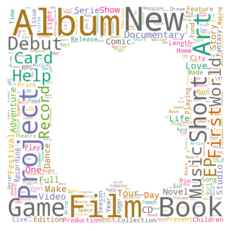

In [ ]:
wordcloud = WordCloud(stopwords=stopwords, mask = mask,  
        random_state=1,
        max_words=300,
        background_color= 'white',
        colormap='Dark2',
        collocations=False,).generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Count plot

In [ ]:
kick_plot=df_upsampled.copy()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


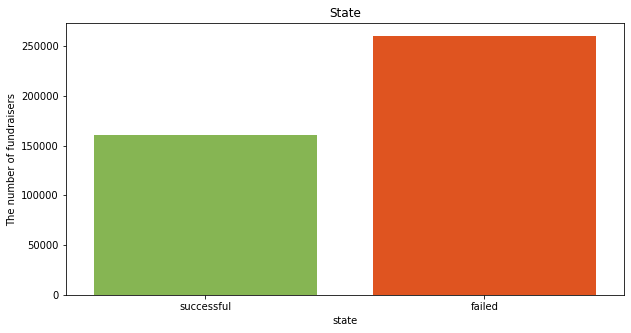

In [ ]:
# Graph how many fundraisers were successful and failed

plt.figure(figsize = (10,5))
sns.countplot(kick_plot['state'], palette = ['#87C543', 'orangered'])
plt.title('State')
plt.ylabel('The number of fundraisers')
plt.show()

## Bar plot before and after oversampling

In [ ]:
kick_bar = kick_set.copy()

# division into US and other countries
kick_bar['country'] = np.where((kick_bar['country'] == 'US'), 'US', 'other')

#groupby
kick_bar= kick_bar.groupby(['country' , 'state'])[['state']].count()


kick_bar.rename({'state' : 'count'}, axis = 1, inplace=True)
kick_bar.reset_index(inplace = True)


# pivot-table

kick_bar = pd.pivot_table(kick_bar, values='count', index=['country'], columns=['state'])


# set column order
kick_bar = kick_bar.reindex(['failed','successful'], axis=1)
kick_bar

state    failed  successful
country                    
US       122764       87368
other     37119       19729

In [ ]:
kick_bar2 = df_upsampled.copy()

# division into US and other countries
kick_bar2['country'] = np.where((kick_bar2['country'] == 'US'), 'US', 'other')

#groupby
kick_bar2= kick_bar2.groupby(['country' , 'state'])[['state']].count()


kick_bar2.rename({'state' : 'count'}, axis = 1, inplace=True)
kick_bar2.reset_index(inplace = True)


# pivot-table

kick_bar2 = pd.pivot_table(kick_bar2, values='count', index=['country'], columns=['state'])


# set column order
kick_bar2 = kick_bar2.reindex(['failed','successful'], axis=1)
kick_bar2

state    failed  successful
country                    
US       122825       87431
other    137292       72964

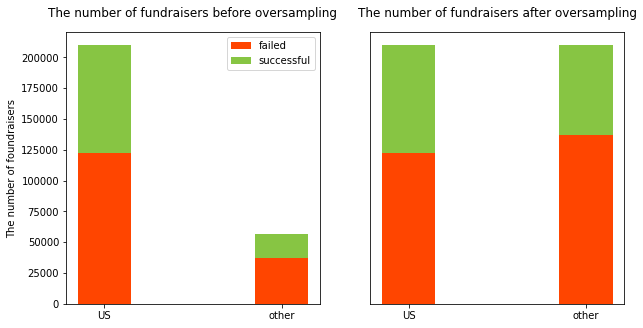

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (10, 5))
# wykres słupkowy

ax[0].bar(kick_bar.index, kick_bar['failed'], label = 'failed', color = 'orangered', width = 0.3)

ax[0].bar(kick_bar.index, kick_bar['successful'],
       bottom = kick_bar['failed'],
       label = 'successful', color='#87C543', width = 0.3)

ax[0].set_ylabel('The number of foundraisers')
ax[0].legend(loc = 'upper right')
ax[0].set_title('The number of fundraisers before oversampling', pad = 15)

#after oversampling

ax[1].bar(kick_bar2.index, kick_bar2['failed'], label = 'failed', color = 'orangered', width = 0.3)

ax[1].bar(kick_bar2.index, kick_bar2['successful'],
       bottom =kick_bar2['failed'],
       label = 'successful', color='#87C543', width = 0.3)

ax[1].set_yticks([])
ax[1].set_title('The number of fundraisers after oversampling', pad = 15)

plt.show()

### Conclusion
Before oversampling, the dataset was not well balanced. In the US, the number of fundraisers was 3.5 times higher than in all other countries combined. After oversampling, the dataset well balanced.

# Models

In [ ]:
df_pipeline = df_upsampled.copy()

In [ ]:
def model_pipeline(dataset, model):
  dataset = dataset.drop(['name', 'category', 'deadline', 'currency', 'launch_date', 'supporters'], axis='columns')
  # Define X and y
  X = dataset[['main_category', 'goal', 'country', 'days', 'launch_hour', 'title_lenght']]
  y=dataset['state']

  # Split data into train, test, validation sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
  # select categorical cols
  categorical_cols =['main_category', 'country',  'launch_hour']

  # select cols
  numerical_cols = [ 'goal',  'days', 'title_lenght']
  categorical_transformer = OneHotEncoder(handle_unknown='ignore')
  numerical_transformer = MinMaxScaler()

  preprocessor = ColumnTransformer(
      transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numerical_cols)])
  my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])
  my_pipeline.fit(X_train, y_train)
  preds = my_pipeline.predict(X_val)
  print_result(calculate_metrics(y_val, preds), model)


In [ ]:
models = [
    KNeighborsClassifier(2), 
    ExtraTreeClassifier(),
    RandomForestClassifier(n_estimators=100, random_state=42),
    ]

for model in models:
  model_pipeline(dataset = df_upsampled, model = model)


Result for KNeighborsClassifier(n_neighbors=2) 

Accuracy: 0.76
Precision: 0.76
Recall: 0.76
F-Score: 0.75
Total: 67282
Mislabeled: 16173 

Result for ExtraTreeClassifier() 

Accuracy: 0.77
Precision: 0.77
Recall: 0.77
F-Score: 0.77
Total: 67282
Mislabeled: 15580 

Result for RandomForestClassifier(random_state=42) 

Accuracy: 0.79
Precision: 0.79
Recall: 0.79
F-Score: 0.79
Total: 67282
Mislabeled: 14155 



In [ ]:
models = [
    XGBClassifier(),
    LGBMClassifier(verbose=-1)]

for model in models:
  model_pipeline(dataset = df_upsampled, model = model)

Result for XGBClassifier() 

Accuracy: 0.68
Precision: 0.67
Recall: 0.68
F-Score: 0.66
Total: 67282
Mislabeled: 21504 

Result for LGBMClassifier(verbose=-1) 

Accuracy: 0.69
Precision: 0.68
Recall: 0.69
F-Score: 0.68
Total: 67282
Mislabeled: 20929 



# Conclusions
Model Random forest was selected for the web app. All calculated metrics for model Random Forest are higher, which means that this model performs better.

# Pipeline for app

In [ ]:
df_pipeline = df_pipeline.drop(['name', 'category', 'deadline', 'currency', 'launch_date', 'supporters'], axis='columns')
df_pipeline

main_category      goal country       state  days launch_hour  \
ID                                                                         
1397944046         Music    6000.0      US  successful  30.0         0-6   
276808753          Games  260000.0      US  successful  37.0        6-12   
1487389447       Theater    4000.0      US  successful  60.0         0-6   
470354679            Art    5000.0      US      failed  30.0        6-12   
704453339         Crafts     500.0      US  successful  30.0       12-18   
...                  ...       ...     ...         ...   ...         ...   
908196269   Film & Video    1000.0      CA      failed  30.0       12-18   
1142622875       Fashion       0.0      CA      failed  30.0         0-6   
24806604           Games   15000.0      CA      failed  32.0       18-22   
1058001538           Art   12210.0      CA  successful  30.0         0-6   
1425188764        Comics     750.0      GB      failed  30.0       12-18   

            title_lenght  
ID                        
1397944046            55  
276808753             43  
1487389447            22  
470354679             35  
704453339             39  
...                  ...  
908196269             23  
1142622875            26  
24806604              15  
1058001538            18  
1425188764            36  

[420512 rows x 7 columns]

In [ ]:
# Define X and y

X = df_pipeline[['main_category', 'goal', 'country', 'days', 'launch_hour', 'title_lenght']]
y=df_pipeline['state']

# Split data into train, test, validation sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [ ]:
# select categorical cols
categorical_cols =['main_category', 'country',  'launch_hour']

# select numerical cols
numerical_cols = [ 'goal',  'days', 'title_lenght']


categorical_transformer = OneHotEncoder(handle_unknown='ignore')
numerical_transformer = MinMaxScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numerical_cols)])

model = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])

In [ ]:
my_pipeline.fit(X_train, y_train)
preds = my_pipeline.predict(X_val)

In [ ]:
print_result(calculate_metrics(y_val, preds), 'Random Forrest - validation')

Result for Random Forrest - validation 

Accuracy: 0.79
Precision: 0.79
Recall: 0.79
F-Score: 0.79
Total: 67282
Mislabeled: 14157 



In [ ]:
# Test set

preds_test = my_pipeline.predict(X_test)
print_result(calculate_metrics(y_test, preds_test), 'Random Forrest - test')

Result for Random Forrest - test 

Accuracy: 0.79
Precision: 0.79
Recall: 0.79
F-Score: 0.79
Total: 84103
Mislabeled: 17799 



In [ ]:
# checking how pipeline works online

data = pd.DataFrame([["Publishing" , 0, 'US' , 30.0, '18-22', 11]], columns = ['main_category',	'goal',	'country',	'days',	'launch_hour',	'title_lenght'])

online_pred = my_pipeline.predict(data)
online_pred

array(['failed'], dtype=object)

In [ ]:
# save pipeline joblib
filename = "pipeline_rf.joblib"
joblib.dump(my_pipeline, filename)

['pipeline_rf.joblib']

In [ ]:
# save pipeline pickle
import pickle

filename = 'pipeline.sav'
pickle.dump(my_pipeline, open(filename, 'wb'))